In [1]:
!pip install tqdm
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.datasets.samples_generator import make_moons
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from tqdm import tqdm

np.random.seed(0)

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
class ActivationFunction:
    name = "base"

    @staticmethod
    def calc(x): return 0

    @staticmethod
    def calc_derivative(x): return 0


class SoftMax(ActivationFunction):
    name = "SoftMax"

    @staticmethod
    def calc(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    @staticmethod
    def calc_derivative(x):
        s = x.reshape(-1, 1)
        return np.diagflat(s) - np.dot(s, s.T)


class HyperbolicTangent(ActivationFunction):
    name = "Hyperbolic Tangent"

    @staticmethod
    def calc(x):
        return np.tanh(x)

    @staticmethod
    def calc_derivative(x):
        return 1.0 - np.tanh(x) ** 2


class ReLU(ActivationFunction):
    name = "ReLU"

    @staticmethod
    def calc(x):
        return x * (x > 0)

    @staticmethod
    def calc_derivative(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x
    
class Sigmoid(ActivationFunction):
    name = "Sigmoid"
    
    @staticmethod
    def calc(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def calc_derivative(x):
        return(np.exp(-x))/((1+np.exp(-x))**2)
        


class ErrorFunction:
    name = "base_error"

    @staticmethod
    def calc(target, prediction):
        return 0

    @staticmethod
    def calc_derivative(target, prediction):
        return 0


class SquareRootError(ErrorFunction):
    name = "Root square mean error"

    @staticmethod
    def calc(target, prediction):
        return np.sqrt(((prediction - target) ** 2).mean())

    @staticmethod
    def calc_derivative(target, prediction):
        return


class CrossEntropy(ErrorFunction):
    name = "Cross entropy loss function"

    @staticmethod
    def calc(target, prediction, epsilon=1e-12):
        prediction = np.clip(prediction, epsilon, 1. - epsilon)
        N = prediction.shape[0]
        ce = -np.sum(np.sum(target*np.log(prediction+1e-9)))/N
        return ce

    @staticmethod
    def calc_derivative(target, prediction):
        return - (target*(1/prediction) +(1-target)*(1/1- prediction))

In [25]:
class Connection:
    def __init__(self, layer, in_size, out_size):
        self._layer = layer
        self._in_size = in_size
        self._out_size = out_size
        self._weights = np.random.rand(out_size, in_size)
        print(self._weights)
        self._biases = np.random.rand(out_size, 1)

    def get_input(self):
        first = self._weights.dot(self._layer.get_result())
        return first + self._biases

    def update_weights(self, deltas):
#         print("Weights")
#         print(self._weights)
#         print("Update")
#         print(deltas)
#         print("Last input")
#         print(self.get_input())
        self._weights -= 0.02 * deltas.dot(self.get_input().T)

    def update_biases(self, deltas):
#         print("Biases:")
#         print(self._biases)
#         print("update:")
        #print(deltas.mean(axis=1).reshape(self._biases.shape))
        self._biases -= 0.02 * deltas.mean(axis=1).reshape(self._biases.shape)


class InputLayer:
    def __init__(self, input_size):
        self._input_size = input_size
        self._results = []

    def forward(self, x):
        self._results = x.T

    def get_result(self):
        return self._results
    
    def backpropagate(self, error):
        return


class Layer:
    def __init__(self, activation_func, out_size):
        self._func = activation_func
        self.out_size = out_size
        self._results = np.zeros(out_size)
        self._last_input = []
        self._connections = []

    def get_result(self):
        return self._results

    def add_connection(self, con):
        self._connections.append(con)

    def forward(self):
        to_pass_in = self._connections[0].get_input()
        for i in range(1, len(self._connections)):
            to_pass_in += self._connections[i].get_input()
        self._last_input = to_pass_in
        self._results = self._func.calc(to_pass_in)

    def backpropagate(self, error_deriv):
#         print("ERROR DERIVATIVE:")
#         print(error_deriv)
#         print("Last input:")
#         print(self._last_input)
#         print(self._func.name + "derivative")
#         print(self._func.calc_derivative(self._last_input))
        grad = error_deriv * self._func.calc_derivative(self._last_input)
        for con in self._connections:
            con.update_weights(grad)
            con.update_biases(grad)
        return grad


class NeuralNet:
    def __init__(self, in_size, out_size, error_func):
        self.error_func = error_func
        self.in_size = in_size
        self.out_size = out_size
        self._layers = []

    def add_layer(self, layer):
        self._layers.append(layer)

    def feed_forward(self, x):
        self._layers[0].forward(x)
        for i in range(1, len(self._layers)):
            self._layers[i].forward()
        return self._layers[-1].get_result()

    def train(self, train_data, train_results, num_epochs, minibatch_size=1):
        for i in range(num_epochs):
            batch_indices = np.random.randint(low=0, high=len(train_data), size=(minibatch_size,))
            batch = train_data[batch_indices]
            error = self.backpropagate(train_results[batch_indices].T, self.feed_forward(batch))
            print("Epoch: " + str(i) + "; Error: " + str(error))

    def predict(self, x):
        return self.feed_forward(self, x)

    def backpropagate(self, target, predicted):
        error = self.error_func.calc(target, predicted)
        to_pass = self.error_func.calc_derivative(target, predicted)
        for x in reversed(self._layers):
            to_pass = x.backpropagate(to_pass)
        return error


In [26]:
net = NeuralNet(2, 2, CrossEntropy)

input_layer = InputLayer(input_size=2)
first_layer = Layer(HyperbolicTangent, out_size=2)
second_layer = Layer(ReLU, out_size=2)
out_layer = Layer(HyperbolicTangent, out_size=2)

input_to_first_connection = Connection(input_layer, 2, 2)
first_layer.add_connection(input_to_first_connection)

first_to_second_connection = Connection(first_layer, 2, 2)
second_layer.add_connection(first_to_second_connection)

second_to_third_connection = Connection(second_layer, 2, 2)
input_to_third_connection = Connection(input_layer, 2, 2)
out_layer.add_connection(second_to_third_connection)
out_layer.add_connection(input_to_third_connection)


net.add_layer(input_layer)
net.add_layer(first_layer)
net.add_layer(second_layer)
net.add_layer(out_layer)

[[0.06691731 0.95797963]
 [0.00416668 0.01299782]]
[[0.35787976 0.94591475]
 [0.36691926 0.83760503]]
[[0.97002048 0.96195287]
 [0.37689292 0.35203186]]
[[0.42262407 0.18462965]
 [0.01476097 0.78654395]]


[ 0.16579966 -0.05146151]


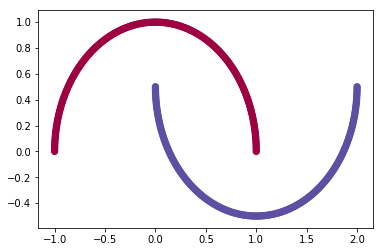

In [27]:

# DATA FOR CLASSIFICATION
# X, y = make_blobs(n_samples=400, centers=2, n_features=2, cluster_std=0.1,random_state=0)
X, y = make_moons(n_samples=400, shuffle=True, noise=None,random_state=0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

reshaped_y = np.array(y).reshape(len(y),1)

enc = OneHotEncoder()
enc.fit(reshaped_y)
encoded_y = enc.transform(reshaped_y).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.33, random_state=42)
# --------------------------
print(X_train[0])

In [17]:
new_Net  = NeuralNet(3, 3, CrossEntropy)

input_layer = InputLayer(input_size=2)
first_layer = Layer(ReLU, out_size=3)
second_layer = Layer(Sigmoid, out_size=3)
out_layer = Layer(SoftMax, out_size=2)

input_to_first_connection = Connection(input_layer, 3, 3)
first_layer.add_connection(input_to_first_connection)

first_to_second_connection = Connection(first_layer, 3, 3)
second_layer.add_connection(first_to_second_connection)

second_to_third_connection = Connection(second_layer, 3, 3)
out_layer.add_connection(second_to_third_connection)


new_Net.add_layer(input_layer)
new_Net.add_layer(first_layer)
new_Net.add_layer(second_layer)
new_Net.add_layer(out_layer)

[[0.66598283 0.84918021 0.02236457]
 [0.02402574 0.03312733 0.0059649 ]
 [0.21354308 0.80429521 0.22041391]]
[[0.07981239 0.28467277 0.57527508]
 [0.2627769  0.62539157 0.65332376]
 [0.5774417  0.44724013 0.26226745]]
[[0.11468552 0.21500829 0.17910146]
 [0.23030677 0.11659476 0.42091003]
 [0.32071262 0.60898833 0.90379224]]


In [18]:
errors = [99999]
m_s = 4
for i in range(len(X_train)):
    randoms = np.random.randint(low=0, high=len(X_train), size=(4,))
#     print(randoms)
#     print(X_train[i:i+4])
#     print(X_train[randoms])
    res = net.feed_forward(X_train[randoms])
    error = net.backpropagate(y_train[randoms].T, res)
    errors.append(error)
    if i % 10 == 0:
        print("ERROR" + str(error))
    if(errors[-1] < 0.0001):
        break

print(errors[-1])
   


    


ERROR0.015038622901383355
ERROR0.01996972654456719
ERROR0.02634712035876976
ERROR0.0036896304025715136
ERROR0.004272956888747944
ERROR0.00150239395825044
ERROR0.0005952869945114967
ERROR0.0016805675743667265
ERROR0.018577264559435425
ERROR0.001979297861470906
ERROR0.0017809827461675418
ERROR0.0008650258956447525
ERROR0.017724420117301968
5.496360277573317e-05


In [8]:
predictions = np.array([[0.25,0.25,0.25,0.25],
                        [0.01,0.01,0.01,0.96]])
targets = np.array([[0,0,0,1],
                  [0,0,0,1]])
ans = 0.71355817782  #Correct answer
x = CrossEntropy.calc(targets, predictions)
print(x)

0.7135581752992395


In [9]:
input = np.array([[0.1, 0.2, 0.7]])
print(input.shape)
res = new_Net.feed_forward(input)
output = np.array([[1.0, 0., 0.]])
to_check = np.array([[0.2698, 0.3223, 0.4078]])
new_Net.backpropagate(output.T, res)

(1, 3)


ValueError: shapes (3,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [28]:
net.train(X_train, y_train, 1000, minibatch_size=100)

Epoch: 0; Error: 2.4518151842312736
Epoch: 1; Error: 0.8384239286710398
Epoch: 2; Error: 0.6717757835618794
Epoch: 3; Error: 0.38547850864115324
Epoch: 4; Error: 0.26636113672065026
Epoch: 5; Error: 0.38027457470864634
Epoch: 6; Error: 0.28413757563439745
Epoch: 7; Error: 0.23959051743823045
Epoch: 8; Error: 0.13647388829666302
Epoch: 9; Error: 0.2099674146852016
Epoch: 10; Error: 0.17102557203255336
Epoch: 11; Error: 0.15012624841607153
Epoch: 12; Error: 0.17359426142673545
Epoch: 13; Error: 0.14888024152303247
Epoch: 14; Error: 0.14469845619251237
Epoch: 15; Error: 0.12640442694753926
Epoch: 16; Error: 0.13228442990364758
Epoch: 17; Error: 0.08970196131362981
Epoch: 18; Error: 0.10467463856279045
Epoch: 19; Error: 0.10039277326623133
Epoch: 20; Error: 0.0840999726715535
Epoch: 21; Error: 0.08321801889576053
Epoch: 22; Error: 0.05582610033100258
Epoch: 23; Error: 0.08388421318806508
Epoch: 24; Error: 0.07100178086455022
Epoch: 25; Error: 0.09325274208317443
Epoch: 26; Error: 0.0776802

Epoch: 315; Error: 0.013091983485872252
Epoch: 316; Error: 0.012614388225168078
Epoch: 317; Error: 0.016905756212228
Epoch: 318; Error: 0.011168158277617798
Epoch: 319; Error: 0.008788512075094597
Epoch: 320; Error: 0.014966779153648377
Epoch: 321; Error: 0.014053883959408393
Epoch: 322; Error: 0.014157137923079252
Epoch: 323; Error: 0.01889849328343491
Epoch: 324; Error: 0.012359941465445515
Epoch: 325; Error: 0.008217285539808755
Epoch: 326; Error: 0.01321415423074364
Epoch: 327; Error: 0.021258268295638885
Epoch: 328; Error: 0.0089455984021144
Epoch: 329; Error: 0.014037182259397337
Epoch: 330; Error: 0.009097709667691722
Epoch: 331; Error: 0.009318979506605499
Epoch: 332; Error: 0.011494943759551474
Epoch: 333; Error: 0.01689141297569343
Epoch: 334; Error: 0.01500172670481492
Epoch: 335; Error: 0.014416365545350593
Epoch: 336; Error: 0.01345822242934055
Epoch: 337; Error: 0.009803259734056019
Epoch: 338; Error: 0.01267890874060162
Epoch: 339; Error: 0.012065781062442571
Epoch: 340;

Epoch: 626; Error: 0.6204987027197801
Epoch: 627; Error: 0.42997215696015373
Epoch: 628; Error: 0.43490576755636146
Epoch: 629; Error: 0.9219721336219298
Epoch: 630; Error: 0.42161625954958387
Epoch: 631; Error: 0.3467577749730886
Epoch: 632; Error: 0.16722974651165454
Epoch: 633; Error: 0.44241935580092645
Epoch: 634; Error: 0.6201761699440617
Epoch: 635; Error: 0.7718193036807538
Epoch: 636; Error: 0.630987582504738
Epoch: 637; Error: 0.4676054577501465
Epoch: 638; Error: 0.32361254545391566
Epoch: 639; Error: 0.27578435861026107
Epoch: 640; Error: 0.38457893646898295
Epoch: 641; Error: 0.7054525385550906
Epoch: 642; Error: 0.6351226439637888
Epoch: 643; Error: 0.22072278983501725
Epoch: 644; Error: 0.3471334666259969
Epoch: 645; Error: 0.9387467132759778
Epoch: 646; Error: 0.24606718453123627
Epoch: 647; Error: 0.5302100077332104
Epoch: 648; Error: 0.6601927417742552
Epoch: 649; Error: 0.8564358232807946
Epoch: 650; Error: 0.801281121511039
Epoch: 651; Error: 0.4713468417138771
Epoc

Epoch: 942; Error: 10.361591479885185
Epoch: 943; Error: 20.78850419210876
Epoch: 944; Error: 20.978682595568554
Epoch: 945; Error: 21.035894395739593
Epoch: 946; Error: 41.447080335715356
Epoch: 947; Error: 41.59683976455362
Epoch: 948; Error: 0.09401789460667695
Epoch: 949; Error: 10.361765381874681
Epoch: 950; Error: 20.76145211437899
Epoch: 951; Error: 0.009652801212407922
Epoch: 952; Error: 20.7267758576441
Epoch: 953; Error: 41.449078958912416
Epoch: 954; Error: 20.750971648061647
Epoch: 955; Error: 20.722791997416085
Epoch: 956; Error: 10.361925882885654
Epoch: 957; Error: 20.776820731682037
Epoch: 958; Error: 21.59133457787711
Epoch: 959; Error: 0.8209862769204717
Epoch: 960; Error: 0.0008315212056518926
Epoch: 961; Error: 10.368701692900942
Epoch: 962; Error: 41.494872528295836
Epoch: 963; Error: 10.531040882818079
Epoch: 964; Error: 20.722480172416642
Epoch: 965; Error: 20.7228680908381
Epoch: 966; Error: 20.79579233550116
Epoch: 967; Error: 10.48164516334636
Epoch: 968; Erro